# Proyecto Fake News - Ciencia de Datos III

En este proyecto, desarrollo una aplicacion de codigo para entrenar un modelo predictivo de procesamiento de lenguaje natural (NLP) utilizando metodos y funciones de la biblioteca **scikit-learn**. El objetivo principal es clasificar articulos de noticias como **reales** o **falsos** (Fake News) basandome en un corpus de datos etiquetados.

A lo largo del proyecto, se realizan:

- **Generacion de WordClouds**: Visualizo las palabras mas frecuentes en los articulos reales y falsos para identificar patrones en el lenguaje utilizado.
- **Analisis de n-grams**: Grafico los n-grams mas comunes (secuencias de palabras) para entender mejor las combinaciones de palabras mas representativas.
- **Entrenamiento y validacion del modelo**: Utilizo tecnicas de machine learning para entrenar un modelo predictivo y finalmente, evaluar y verificar su rendimiento en datos de prueba.

Este proyecto no solo me permite aplicar tecnicas de NLP y machine learning, sino tambien explorar como los datos textuales pueden ser utilizados para resolver problemas practicos mas alla de la deteccion de sentimniento; como en este caso la deteccion de noticias falsas. 

## Librerias Utilizadas

Empezamos el proyecto cargando las librerias necesarias para el procesamiento de los datos.

- **nltk**: Biblioteca para procesamiento de lenguaje natural, utilizada para tokenizacion, lematizacion y manejo de stopwords.
- **spacy**: Herramienta avanzada para NLP, usada para tareas como tokenizacion y analisis de texto.
- **pandas**: Utilizada para manipular y analizar dataframes.
- **numpy**: Biblioteca para operaciones matematicas.
- **seaborn**: Usada para crear graficos estadisticos.
- **matplotlib**: Biblioteca para visualizacion de datos, utilizada para graficar n-grams y otros analisis.
- **wordcloud**: Genera nubes de palabras para visualizar las palabras mas frecuentes en el dataset.
- **collections.Counter**: Herramienta para contar elementos en listas, usada para analizar la frecuencia de palabras o n-grams.
- **sklearn**: Biblioteca de machine learning utilizada para dividir los datos, vectorizar texto, construir pipelines y entrenar modelos como Naive Bayes.

In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


#### Corpus

El corpus o dataset utilizado en este proyecto es un conjunto de articulos de noticias estadounidenses que se clasifican como Fake o Real News. El dataset incluye textos scrapeados de fuentes variadas: BBC, New York Times, The Sun, entre muchos otros fuentes de informacion cuestionable.

https://raw.githubusercontent.com/lutzhamel/fake-news/refs/heads/master/data/fake_or_real_news.csv


In [ ]:
# Cargar modelo de spaCy en inglés

nlp = spacy.load("en_core_web_sm")


In [ ]:
# Cargar el dataset usando Pandas

df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

### Pregunta del Profe

**'"Està balanceado? Bastantre bien balanceado. Còmo lo arreglarìas si no?"'**

El dataset esta balanceado pues tiene cantidades similares de datos Fake asi como Reales. 
Adicionalmente si mi dateset no estuviera balanceado, yo intentaria un muestreo estratificado para procurar tomar la misma cantidad de datos de ambas clases.

In [ ]:
# Contar cuantas noticias reales y fakes hay en el dataset

df.head()
df['sentimiento'].value_counts()


sentimiento
REAL    3171
FAKE    3164
Name: count, dtype: int64

#### Input del Profe 

**'En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning? '**

Desde el vamos, puedo observar que este dataframe tiene muchisimo menos columnas que aquellos que usaba para Ciencia de Datos 2.

In [ ]:
# Dimensiona el dataset, muestro las dimensiones del dataset mostrando (filas, columnas)

df.shape

(6335, 4)

Para poder procesar los datos de mi modelo de prediccion, necesito dividir el dataset en subconjuntos:

1. Subconjunto de Entrenamiento, `Train` consistiendo del 75% de los datos
2. Subconjunto de Evaluacion, `Test` consistiendo del 25% restante

Cabe mencionar que estoy usando un random_state establecido para generar los mismos datos cada vez que ejecuto este bloque de programacion.

In [6]:
train, test = train_test_split(df, test_size=None, train_size=None, random_state=12, shuffle=True, stratify=None)
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
print("El dataframe de Train tiene las siguientes dimensiones ",train.shape)
print("El dataframe de Test tiene las siguientes dimensiones ",test.shape)
# Las clases quedaron balanceadas? No, no han quedado balanceadas. Sin embargo, creo que es el tamano predeterminado, tipo 75/25

El dataframe de Train tiene las siguientes dimensiones  (4751, 4)
El dataframe de Test tiene las siguientes dimensiones  (1584, 4)


Se utiliza el metodo `train.head()` para mostrar las primeras filas del conjunto de datos de entrenamiento y asi verificar que los datos se hayan dividido correctamente.

In [7]:
train.head()

,Unnamed: 0,title,texto,sentimiento
4525,2016,Is Jeb Bush conservative enough?,"Washington (CNN) He cut billions in taxes, int...",REAL
2739,6060,Self-Driving Truck’s First Mission: A 120-Mile...,New York Times – by Mike Isaac SAN FRANCISCO —...,FAKE
221,5918,Trump’s Gettysburg Address against the New Wor...,Tweet Home » Headlines » Finance News » Trump’...,FAKE
5290,2206,New tensions erupt between the White House and...,Tensions between the White House and Benjamin ...,REAL
4962,3797,Obama Will Address Hillary’s Email Scandal on ...,President Obama is appearing on Fox’s Sunday p...,REAL


## Ajustar Etiquetas de Sentimiento

En este bloque se ajustan las etiquetas del dataset para representar las clases de manera consistente. Se asigna el valor **0** a las noticias falsas (**Fake**) y el valor **1** a las noticias reales (**Real**). Para facilitar el entrenamiento del modelo al trabajar con etiquetas binarias.

In [ ]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)

train['sentimiento'] =  train['sentimiento'].replace({'REAL': 1, 'FAKE': 0})
test['sentimiento'] =  test['sentimiento'].replace({'REAL': 1, 'FAKE': 0})

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10860\1365180643.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['sentimiento'] =  train['sentimiento'].replace({'REAL': 1, 'FAKE': 0})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10860\1365180643.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['sentimiento'] =  test['sentimiento'].replace({'REAL': 1, 'FAKE': 0})


Se utiliza el metodo `train.head()` y `test.head()` para mostrar las primeras filas de los dataset de entrenamiento y evaluacion para corroborar que los datos se han procesado de manera correcta.

In [9]:
train.head()
test.head()

,Unnamed: 0,title,texto,sentimiento
3779,6334,BREAKING: DOJ FINALLY Secures Warrant To Inspe...,BREAKING: DOJ FINALLY Secures Warrant To Inspe...,0
2287,1082,Is the GOP's stop Trump campaign too late?,Washington (CNN) The Republican Party is wakin...,1
6170,8410,The Dark Agenda Behind Globalism And Open Borders,The Dark Agenda Behind Globalism And Open Bord...,0
2368,6063,"Janet Reno, First Female US Attorney General, ...","Janet Reno, First Female US Attorney General, ...",0
299,2989,Rand Paul Goes on Senate Floor to Protest NSA ...,Congress faces a June 1 deadline for the law's...,1


Esta funcion realiza el preprocesamiento de un texto individual utilizando herramientas de NLP. Los pasos principales incluyen:

- **Tokenizacion**: Divide el texto en palabras individuales (tokens).
- **Eliminacion de stopwords**: Filtra palabras comunes que no aportan significado (como "the", "and", etc.).
- **Lematizacion**: Convierte las palabras a su forma base (por ejemplo, "running" a "run").
- **Filtrado de caracteres no alfabeticos**: Solo se conservan palabras que contienen caracteres alfabeticos.

El resultado es un texto limpio y procesado, listo para ser utilizado en el modelo de machine learning.


In [10]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

Esta funcion es una version optimizada para procesar multiples textos al mismo tiempo utilizando el metodo `pipe` de spaCy. Los pasos principales son:

- **Procesamiento en lotes**: Utiliza `nlp.pipe` para procesar textos en lotes, lo que mejora la velocidad al evitar procesar texto por texto.
- **Lematizacion y filtrado**: Extrae las lemas de las palabras, eliminando stopwords y palabras no alfabeticas.
- **Union de tokens**: Combina los tokens procesados en un texto limpio.

El resultado es una lista de textos preprocesados, lista para ser utilizada en tareas de NLP como vectorizacion o entrenamiento de modelos.

In [ ]:
def preprocesar_texto_pipe(texts):
    """Utilizo una pipeline para procesar los textos de manera simultanea."""
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
        processed_texts.append(" ".join(tokens))
    return processed_texts

En este bloque se aplica la funcion `preprocesar_texto_pipe` a toda la columna de texto del dataset. Esto asegura que todos los articulos sean limpiados y procesados de manera uniforme, eliminando ruido como stopwords y palabras no alfabeticas, y convirtiendo las palabras a su forma base (lemas). El resultado es una nueva columna con los textos preprocesados, lista para ser utilizada en el modelo de machine learning.

In [ ]:
# Aplico el pre-procesamiento de texto a la columna 'texto' del dataset de train
train["texto_procesado"] = preprocesar_texto_pipe(train['texto'].astype(str))

# Muestro las primeras filas de mis resultados
print(train['texto_procesado'].head())

#Un-Fun fact: Tarda 13 minutos 1.7 s para procesarse en mi PC

4525    Washington CNN he cut billion taxis intervene ...
2739    New York Times Mike Isaac SAN FRANCISCO the fu...
221     Tweet Home Headlines Finance News Trump Gettys...
5290    tension White House Benjamin Netanyahu escalat...
4962    President Obama appear Fox Sunday politic show...
Name: texto_procesado, dtype: object


Aplicar preprocesamiento puede ser muy lento, previamente use un NLP Pipe para mejorar el tiempo de procesamiento de mi codigo. 
En la primera etapa de mi tarea intente usar las siguientes lineas de codigo:
```python
#train["texto_procesado"]=train['texto'].apply(preprocesar_texto)
#print(train['texto_procesado'].head())
```
Pero cuando llegue al minuto 15 de procesamiento decidi abortar y buscar otra alternativa.

Ni siquiera voy a intentar dejar que mi PC termine de procesar esa info, jajas.

In [ ]:
# Aplico el pre-procesamiento de texto a la columna 'texto' del dataset de test

test["texto_procesado"] = preprocesar_texto_pipe(test['texto'].astype(str))

# Muestro las primeras filas de mis resultados
print(test['texto_procesado'].head())

#Un-Fun fact: Tarda 4 minutos 13.8 s para procesarse en mi PC

3779    breaking DOJ finally secure Warrant to inspect...
2287    Washington CNN the Republican Party wake might...
6170    the Dark Agenda behind Globalism and Open Bord...
2368    Janet Reno First Female US Attorney General di...
299     Congress face June deadline law expiration Pau...
Name: texto_procesado, dtype: object


## Nubes de Palabras

Para generar las nubes de palabras, utilice la biblioteca **WordCloud**. He creao tres nubes separadas: una para las palabras mas frecuentes en el dataset de Entrenamiento, otra para el dataset de Evaluacion y una combinada para todo el dataset. Esto me permitio visualizar patrones en el lenguaje utilizado en cada categoria.

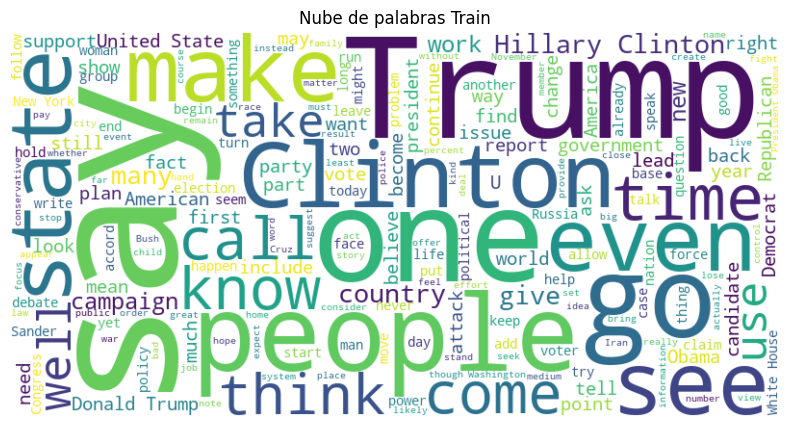

In [ ]:
#Nube de Palabras para Train
text_combined = " ".join(train['texto_procesado'])
#Este bloque genera el wordcloud del dataset "Train"
text_combined = " ".join(train['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras Train")
plt.show()

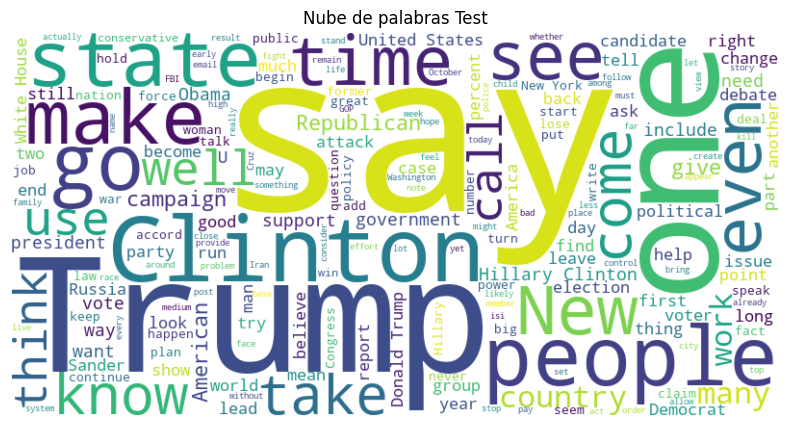

In [ ]:
#Nube de Palabras para Test
test_combined = " ".join(test['texto_procesado'])
#Este bloque genera el wordcloud del dataset "Test"
test_combined = " ".join(test['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(test_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras Test")
plt.show()

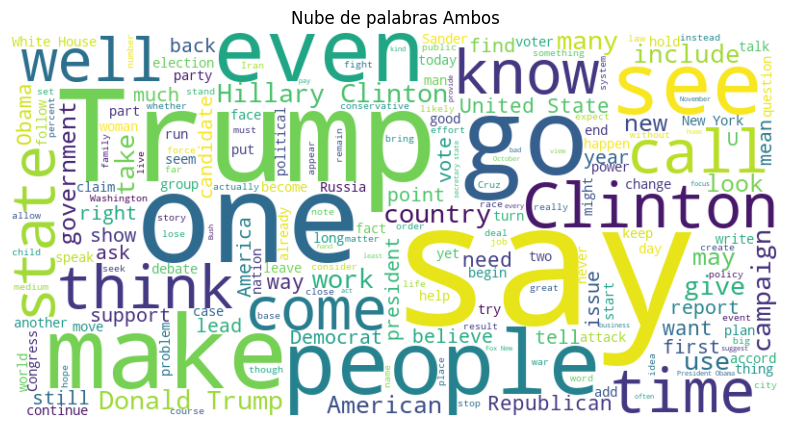

In [ ]:
# Visualizar nube de palabras de los datasets combinados

text_combined = pd.concat([train['texto_procesado'], test['texto_procesado']], axis=0, ignore_index=True)

# Unir los textos de ambos datasets en un solo string
text_string = text_combined.str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras Ambos")
plt.show()

## Analisis de n-grams

En este bloque, realizo un analisis de los n-grams (combinaciones de palabras) mas frecuentes en el dataset. Genero bigramas, trigramas y cuatrigramas para identificar patrones en las secuencias de palabras utilizadas en las noticias. Posteriormente, ploteo los resultados para visualizar las combinaciones mas comunes y su frecuencia, lo que ayuda a entender mejor el lenguaje caracteristico de cada categoria.

Unigramas más comunes:
    N-gram  Frecuencia
0      the       22985
1      say       22935
2    trump       17303
3  clinton       12972
4    would       10051
5    state        9519
6      one        9295
7   people        8838
8     make        7887
9       go        7632


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10860\236235585.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


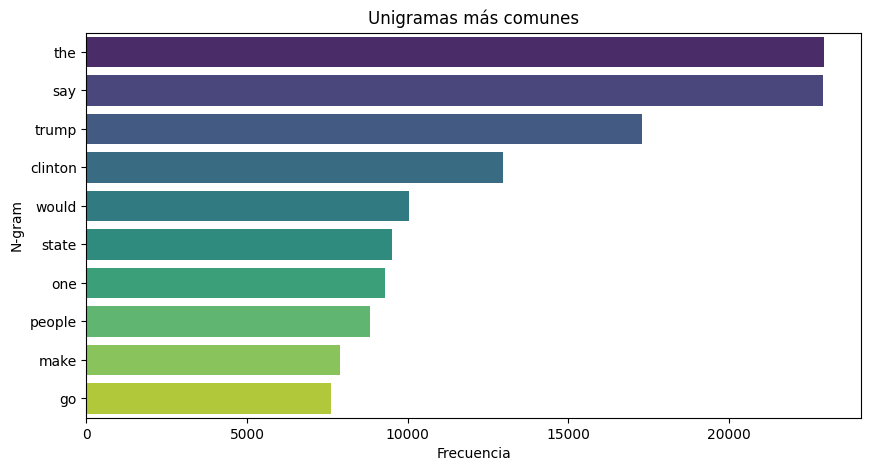

In [18]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(train['texto_procesado'], 1)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")



Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton        3191
1     donald trump        2888
2    united states        2253
3      white house        1702
4         new york        1678
5  president obama         959
6  secretary state         903
7         fox news         881
8        trump say         778
9         year old         749


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10860\236235585.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


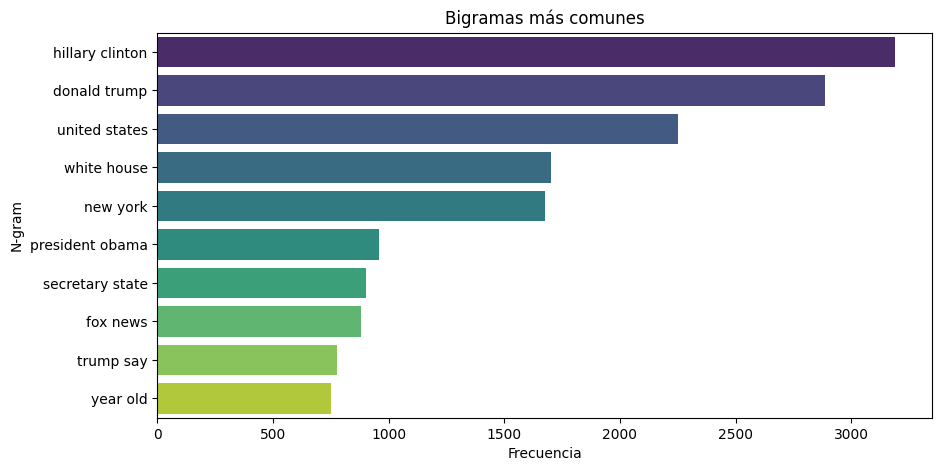

In [19]:
#Genero Bigramas
bigrams = get_top_ngrams(train['texto_procesado'], 2)

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")


Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         445
1             president barack obama         309
2               the associated press         205
3             former secretary state         203
4            president united states         201
5                       the new york         183
6               director james comey         165
7                      new york city         165
8                wall street journal         164
9  republican presidential candidate         159


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10860\236235585.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


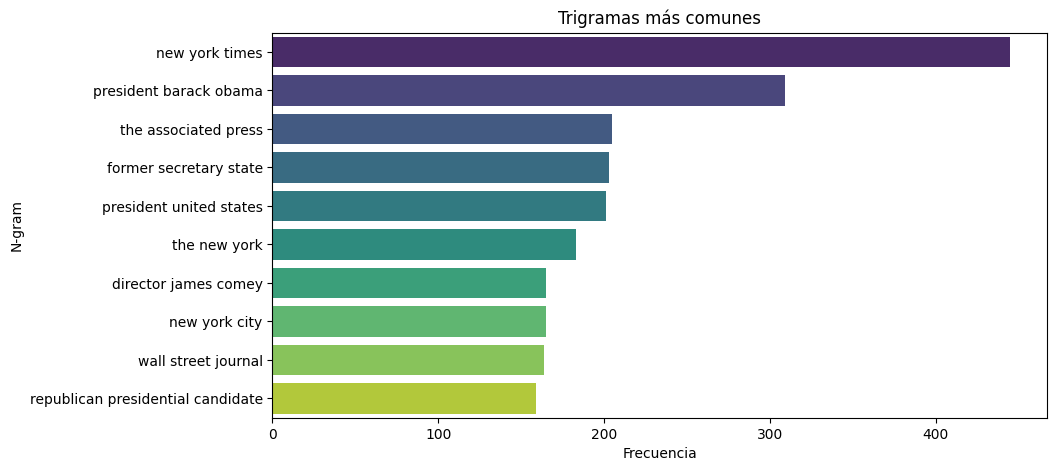

In [20]:
# Genero Trigrams
trigrams = get_top_ngrams(train['texto_procesado'], 3)
print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

## Pipeline de Vectorizacion y Modelo

En este bloque se define un pipeline que combina dos pasos principales: la **vectorizacion** del texto y el **entrenamiento del modelo**. Primero, se utiliza un vectorizador como `TfidfVectorizer` o `CountVectorizer` para convertir los textos preprocesados en representaciones numericas que el modelo puede entender. Luego, se entrena un modelo de machine learning, como `MultinomialNB` (Naive Bayes), para clasificar las noticias como reales o falsas. Este pipeline automatiza el flujo de trabajo, asegurando que los datos pasen por el vectorizador antes de ser procesados por el modelo. Esto facilita la reproducibilidad y simplifica el proceso de prediccion.

In [21]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

## Entrenamiento del Modelo NLP

En este bloque se entrena el modelo utilizando el pipeline previamente definido. El modelo aprende a clasificar las noticias como reales o falsas basándose en los textos vectorizados del conjunto de entrenamiento.

In [22]:
# Entrenar modelo
pipeline.fit(train['texto_procesado'], train['sentimiento'])
y_train=train['sentimiento']
y_test=test['sentimiento']
# Predicciones
y_pred = pipeline.predict(test['texto_procesado'])
y_pred

array([0, 1, 0, ..., 1, 0, 1])

Se evalua el rendimiento del modelo utilizando el conjunto de prueba. Se calcula la precision (**accuracy**) y se genera un reporte de clasificacion que incluye metricas como precision, recall y F1-score para cada clase.

In [ ]:
# Evaluacion
print("Accuracy:", accuracy_score(test['sentimiento'], y_pred))
print(classification_report(test['sentimiento'], y_pred))


Accuracy: 0.8434343434343434
              precision    recall  f1-score   support

           0       0.97      0.70      0.82       787
           1       0.77      0.98      0.86       797

    accuracy                           0.84      1584
   macro avg       0.87      0.84      0.84      1584
weighted avg       0.87      0.84      0.84      1584



Se inicializa un `TfidfVectorizer`, que convierte los textos en representaciones numéricas basadas en la frecuencia de términos, ajustada por su importancia en el corpus. Esto ayuda a capturar las palabras más relevantes para la clasificación.

In [24]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(train['texto'])
tfidf_test = tfidf_vectorizer.transform(test['texto'])

En este bloque se importa el clasificador **PassiveAggressiveClassifier** de scikit-learn. Este modelo es un algoritmo de aprendizaje supervisado que se utiliza para problemas de clasificación. Este modelo es eficiente, pues actualiza su modelo de manera agresiva solo cuando comete errores, manteniendo su modelo pasivo en otros casos. Es ideal para procesamiento de grandes textos.

In [25]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

En este bloque se utiliza el modelo entrenado (`pac`) para predecir las etiquetas del conjunto de prueba (`tfidf_test`). El resultado, almacenado en `y_pred2`, contiene las predicciones del modelo sobre si las noticias son reales o falsas, basándose en los textos vectorizados.

In [26]:
y_pred2=pac.predict(tfidf_test)

Finalmente, se evalua el rendimiento del modelo utilizando el conjunto de prueba. Calculo la precision (**accuracy**) y... Sorpresa! Mejora bastante la prediccion de este modelo. Obteniendo un 95.0126% de precision, 95% de recall y 95% de F1-Score.

In [27]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.9501262626262627
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       787
           1       0.95      0.95      0.95       797

    accuracy                           0.95      1584
   macro avg       0.95      0.95      0.95      1584
weighted avg       0.95      0.95      0.95      1584



## Conclusiones

En este proyecto, logre construir y evaluar un modelo de clasificacion de texto para detectar noticias falsas utilizando tecnicas de procesamiento de lenguaje natural y machine learning. A traves del preprocesamiento de texto, la vectorizacion con **TfidfVectorizer** y el uso de modelos como **PassiveAggressiveClassifier**, pude entrenar un modelo eficiente para clasificar noticias como reales o falsas.

Ademas, explore el dataset generando nubes de palabras y analizando n-grams, lo que me permitio identificar patrones en el lenguaje utilizado en cada categoria. Este analisis ayudo a entender mejor las caracteristicas que diferencian las noticias reales de las falsas.

El modelo final mostro un desempeno satisfactorio en terminos de precision y otras metricas, demostrando que es posible abordar el problema de las Fake News con herramientas de NLP y machine learning. Este proyecto me permitio reforzar conceptos clave y aplicar tecnicas practicas que seran utiles en futuros proyectos relacionados con el analisis de texto.
